In [1]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt

#### Функции

In [2]:
# Диаграмма нулей и полюсов
def ZerosPolesDiagram(z, p):
    fg, ax = plt.subplots(figsize=(5, 5))
    circle = plt.Circle(xy=(0,0),radius=1, edgecolor='gray', facecolor='white', linestyle='--')
    ax.add_patch(circle)
    ax.scatter(z.real, z.imag, marker='o', facecolor='white', edgecolor='C0', s=100)
    ax.scatter(p.real, p.imag, marker='x', s=100)
    ax.axhline(y=0, color="black", linestyle="-")
    ax.axvline(x=0, color="black", linestyle="-")
    ax.grid()
    plt.show()

# Расчет АЧХ
def FrequencyResponse(h):
    with np.errstate(divide='ignore'): # suppress RuntimeWarning: divide by zero encountered in log10
        return 20 * np.log10(abs(h))

# Расчет ФЧХ
def PhaseResponse(h):
    return np.unwrap(np.angle(h))

# Графики АЧХ и ФЧХ
def FRPRDiagram(w, fr, pr, logx = False, **kwargs):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,5), layout='constrained')

    if (logx):
        ax[0].semilogx(w, fr, 'b')
    else:
        ax[0].plot(w, fr, 'b')
    ax[0].set_ylabel('Амплитуда, дБ', color='b')
    ax[0].set_xlabel('Частота, рад/с')
    ax[0].grid(True)

    if (logx):
        ax[1].semilogx(w, pr, 'g')
    else:
        ax[1].plot(w, pr, 'g')
    ax[1].set_ylabel('Фаза, рад', color='g')
    ax[1].set_xlabel('Частота, рад/с')
    ax[1].grid(True)

    if 'title' in kwargs.keys():
        fig.suptitle(kwargs['title'])

    if 'ylimits' in kwargs.keys():
        ax[0].set_ylim(kwargs['ylimits'])

    if 'xvlines' in kwargs.keys():
        for xvline in kwargs['xvlines']:
            for axis in ax:
                axis.axvline(x=xvline, color='gray', linestyle='dashed', linewidth=1.5)
    
    plt.show()

# Оболочка для отрисовки графика при вызове функций freqs и freqz в линейном масштабе
def FRPRDiag (w, h):
    FRPRDiagram(w, FrequencyResponse(h), PhaseResponse(h), logx=False)

# Оболочка для отрисовки графика при вызове функций freqs и freqz в логарифмическом масштабе
def FRPRDiagLog (w, h):
    FRPRDiagram(w, FrequencyResponse(h), PhaseResponse(h), logx=True)


#### Дискретизация аналоговых фильтров при помощи билинейного преобразования

##### Эллиптический фильтр нижних частот

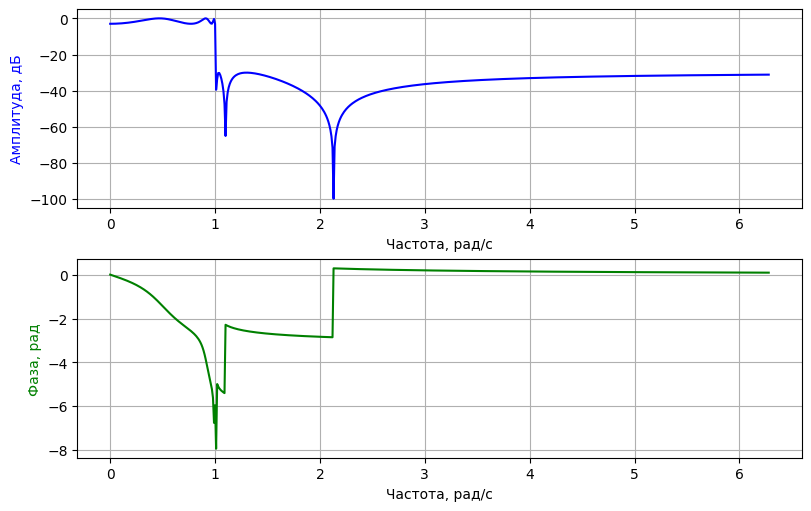

In [3]:
# Синтез прототипа аналогового эллиптического фильтра
# Возвращаемые значения:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# Параметры:
# N - порядок фильтра
# rз - допустимый уровень пульсаций в полосе пропускания
# rs - допустимый уровень пульсаций в полосе подавления
z, p, k = sp.ellipap(N=10, rp=3, rs=30)

# Преобразование прототипа фильтра нижних частот, представленного в виде значений нулей, полюсов и коэффициента усиления
# в форму коэффициентов прямых и обратных связей
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
b, a = sp.zpk2tf(z=z, p=p, k=k)

# Функция freqs возвращает отклик аналогового фильтра, представленного в виде коэффициентов прямых и обратных связей
# Возвращаемые значения:
# w - частоты, для которых был рассчитан отклик фильтра
# h - отклик фильтра, представленный в виде комплексных чисел
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# worN - количество вычисляемых откликов или массив частот, для которых требуется вычислить отклик
# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
_ = sp.freqs(b=b, a=a, worN=np.arange(start=0, stop=2*np.pi, step=0.01), plot=FRPRDiag)

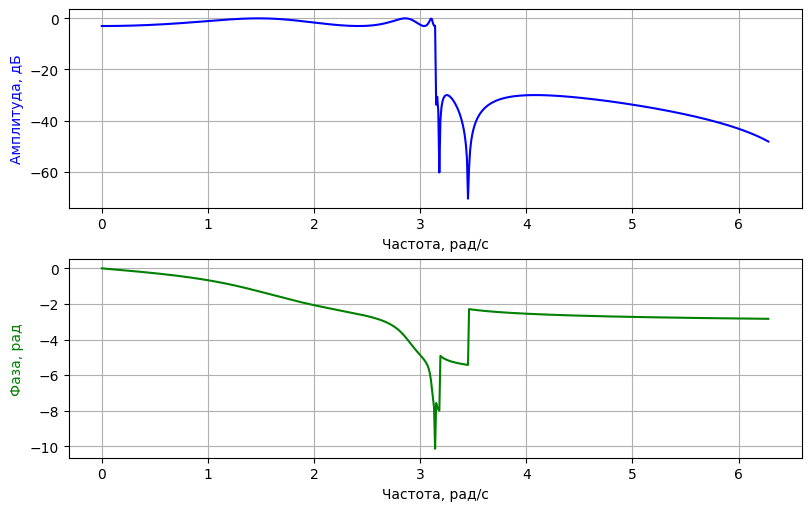

In [4]:
# Новая частота среза
wo = np.pi
# Частота дискретизации
fs = 10
# Pre-wrapped частота среза для использования в функции билинейного преобразования
pwwo = 2*fs*np.tan(wo*(2*np.pi/fs)/2)

# Синтез фильтра нижних частот по характеристикам прототипа
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# wo - новая частота среза
bt, at = sp.lp2lp(b=b, a=a, wo=wo)

# Функция freqs возвращает отклик аналогового фильтра, представленного в виде коэффициентов прямых и обратных связей
# Возвращаемые значения:
# w - частоты, для которых был рассчитан отклик фильтра
# h - отклик фильтра, представленный в виде комплексных чисел
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# worN - количество вычисляемых откликов или массив частот, для которых требуется вычислить отклик
# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
_ = sp.freqs(b=bt, a=at, worN=np.arange(start=0, stop=2*np.pi, step=0.01), plot=FRPRDiag)

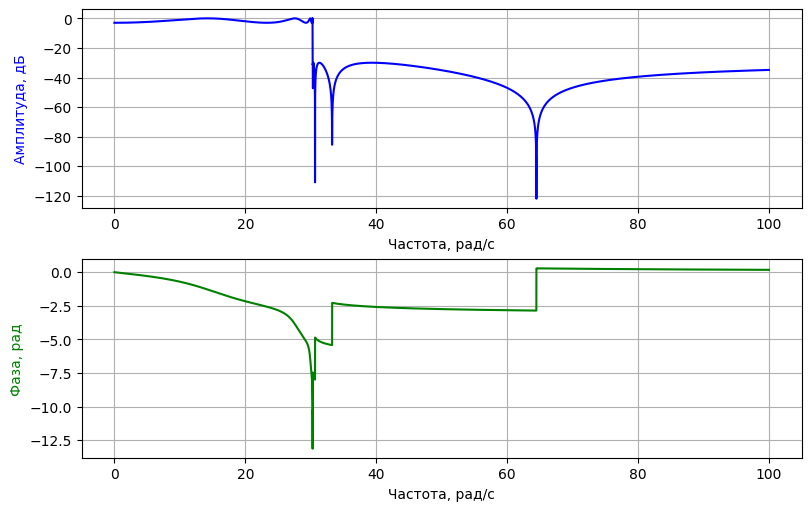

In [5]:
# Синтез фильтра нижних частот по характеристикам прототипа для pre-wrapped частоты
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# wo - новая частота среза
bt, at = sp.lp2lp(b=b, a=a, wo=pwwo)

# Функция freqs возвращает отклик аналогового фильтра, представленного в виде коэффициентов прямых и обратных связей
# Возвращаемые значения:
# w - частоты, для которых был рассчитан отклик фильтра
# h - отклик фильтра, представленный в виде комплексных чисел
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# worN - количество вычисляемых откликов или массив частот, для которых требуется вычислить отклик
# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
_ = sp.freqs(b=bt, a=at, worN=np.arange(start=0, stop=100, step=0.01), plot=FRPRDiag)

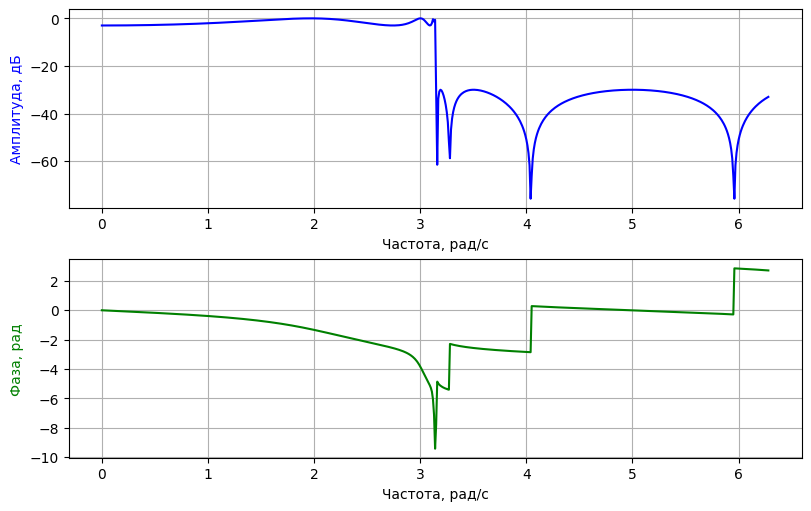

In [6]:
# Функция bilinear синтезирует цифровой фильтр из аналогового при помощи билинейного преобразования
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# fs - частота дискретизации
b2, a2 = sp.bilinear(b=bt, a=at, fs=10)

# Функция freqz возвращает отклик цифрового фильтра, представленного в виде коэффициентов прямых и обратных связей
# Возвращаемые значения:
# w - частоты, для которых был рассчитан отклик фильтра
# h - отклик фильтра, представленный в виде комплексных чисел
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# worN - количество вычисляемых откликов или массив частот, для которых требуется вычислить отклик
# whole - False: вычисляется отклик на частоты от 0 до частоты Найквиста, True: вычисляется отклик на частоты от 0 до частоты дискретизации
# fs - частота дискретизации
# include_nyquist - вычислять отклик для частоты Найквиста, который по умолчанию не вычисляется
# Функция freqz позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
_ = sp.freqz(b=b2, a=a2, worN=np.arange(start=0, stop=2*np.pi, step=0.01), fs=10, plot=FRPRDiag)

##### Эллиптический полосовой фильтр

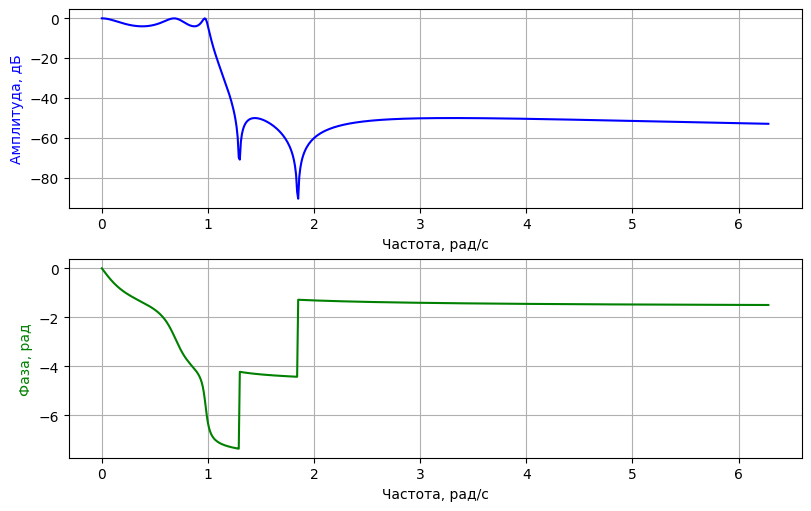

In [7]:
# Синтез прототипа аналогового эллиптического фильтра
# Возвращаемые значения:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# Параметры:
# N - порядок фильтра
# rз - допустимый уровень пульсаций в полосе пропускания
# rs - допустимый уровень пульсаций в полосе подавления
z, p, k = sp.ellipap(N=5, rp=4, rs=50)

# Преобразование прототипа фильтра нижних частот, представленного в виде значений нулей, полюсов и коэффициента усиления
# в форму коэффициентов прямых и обратных связей
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
b, a = sp.zpk2tf(z=z, p=p, k=k)

# Функция freqs возвращает отклик аналогового фильтра, представленного в виде коэффициентов прямых и обратных связей
# Возвращаемые значения:
# w - частоты, для которых был рассчитан отклик фильтра
# h - отклик фильтра, представленный в виде комплексных чисел
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# worN - количество вычисляемых откликов или массив частот, для которых требуется вычислить отклик
# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
_ = sp.freqs(b=b, a=a, worN=np.arange(start=0, stop=2*np.pi, step=0.01), plot=FRPRDiag)

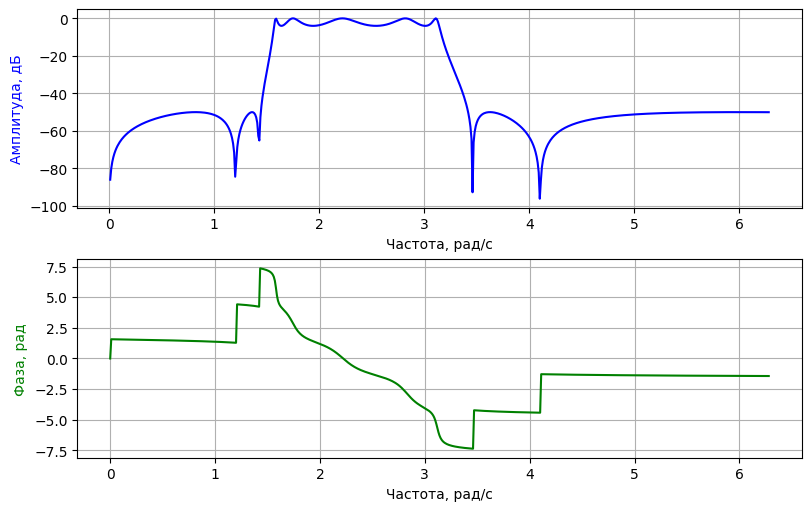

In [8]:
# Частоты среза
w1 = 0.5*np.pi
w2 = np.pi
# Частота середины полосы пропускания
wo = np.sqrt(w1 * w2)
# Ширина полосы пропускания
bw = w2 - w1
# Частота дискретизации
fs = 10

# Pre-wrapped частоты среза для использования в функции билинейного преобразования
pww1 = 2*fs*np.tan(w1*(2*np.pi/fs)/2)
pww2 = 2*fs*np.tan(w2*(2*np.pi/fs)/2)
# Pre-wrapped частота середины полосы пропускания
pwwo = np.sqrt(pww1 * pww2)
# Ширина полосы пропускания для pre-wrapped частот
pwbw = pww2 - pww1

# Синтез полосового фильтра по характеристикам прототипа
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# wo - частота середины полосы пропускания
# bw - ширина полосы пропускания
bt, at = sp.lp2bp(b=b, a=a, wo=wo, bw=bw)

# Функция freqs возвращает отклик аналогового фильтра, представленного в виде коэффициентов прямых и обратных связей
# Возвращаемые значения:
# w - частоты, для которых был рассчитан отклик фильтра
# h - отклик фильтра, представленный в виде комплексных чисел
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# worN - количество вычисляемых откликов или массив частот, для которых требуется вычислить отклик
# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
_ = sp.freqs(b=bt, a=at, worN=np.arange(start=0, stop=2*np.pi, step=0.01), plot=FRPRDiag)

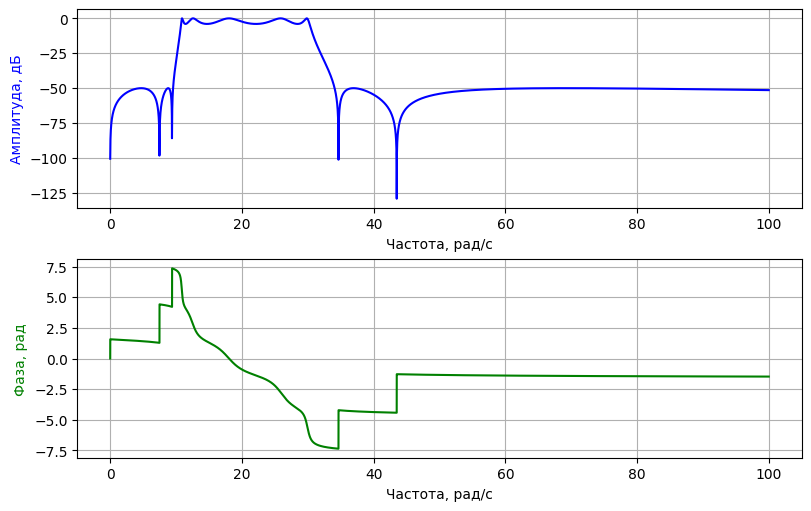

In [9]:
# Синтез полосового фильтра по характеристикам прототипа для pre-wrapped частоты
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# wo - частота середины полосы пропускания
# bw - ширина полосы пропускания
bt, at = sp.lp2bp(b=b, a=a, wo=pwwo, bw=pwbw)

# Функция freqs возвращает отклик аналогового фильтра, представленного в виде коэффициентов прямых и обратных связей
# Возвращаемые значения:
# w - частоты, для которых был рассчитан отклик фильтра
# h - отклик фильтра, представленный в виде комплексных чисел
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# worN - количество вычисляемых откликов или массив частот, для которых требуется вычислить отклик
# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
_ = sp.freqs(b=bt, a=at, worN=np.arange(start=0, stop=100, step=0.01), plot=FRPRDiag)

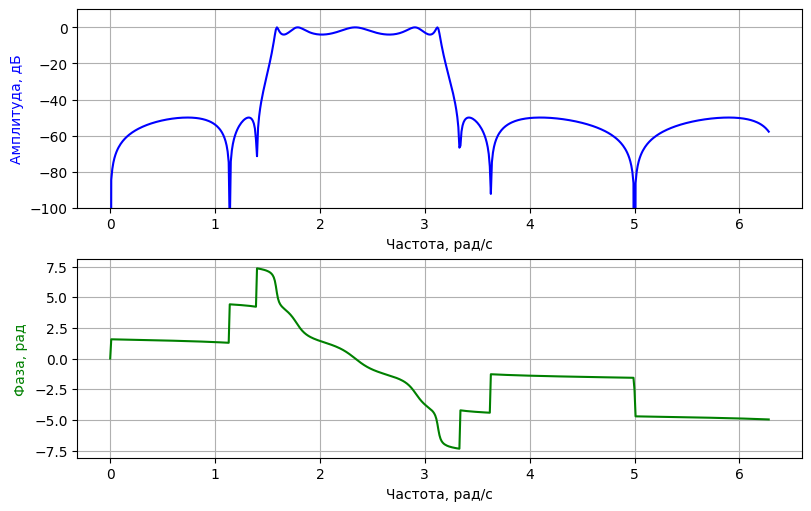

In [10]:
# Функция bilinear синтезирует цифровой фильтр из аналогового при помощи билинейного преобразования
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# fs - частота дискретизации
b2, a2 = sp.bilinear(b=bt, a=at, fs=10)

# Функция freqz возвращает отклик цифрового фильтра, представленного в виде коэффициентов прямых и обратных связей
# Возвращаемые значения:
# w - частоты, для которых был рассчитан отклик фильтра
# h - отклик фильтра, представленный в виде комплексных чисел
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# worN - количество вычисляемых откликов или массив частот, для которых требуется вычислить отклик
# whole - False: вычисляется отклик на частоты от 0 до частоты Найквиста, True: вычисляется отклик на частоты от 0 до частоты дискретизации
# fs - частота дискретизации
# include_nyquist - вычислять отклик для частоты Найквиста, который по умолчанию не вычисляется
# Функция freqz позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
w, h = sp.freqz(b=b2, a=a2, worN=np.arange(start=0, stop=2*np.pi, step=0.01), fs=10)
FRPRDiagram(w=w, fr=FrequencyResponse(h=h), pr=PhaseResponse(h=h), ylimits=(-100, 10))